# Basic Initialization on Dataset

Fun datasets at https://github.com/deric/clustering-benchmark/tree/master/src/main/resources/datasets/artificial

In [6]:
# Animation class definition
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from sklearn.neighbors import LocalOutlierFactor

class LOFAnimation:
    def __init__(self, data, n_range=range(1,25), min_lof=1.5):
        if len(data.shape) != 2 or data.shape[1] != 2:
            raise ValueError("Input must be 2D")
        self.data = data
        self.n_range = n_range
        self.min_lof = min_lof
        self.fig, self.ax = plt.subplots(figsize=(8,8))
        self.anim = animation.FuncAnimation(
            self.fig, self.animate,
            init_func=self.setup_plot,
            frames=self.n_range,
            interval=500,
            blit=True
        )

    def setup_plot(self):
        self.scatter = self.ax.scatter(self.data[:,0], self.data[:,1], s=10, facecolors='c')
        self.outliers = self.ax.scatter([],[], facecolors='none', edgecolors='r')
        self.annotations = []
        return self.outliers,

    def animate(self, n):
        clf = LocalOutlierFactor(n_neighbors=n)
        clf.fit_predict(self.data)
        out_idx = clf.negative_outlier_factor_ < -self.min_lof
        outliers = self.data[out_idx,:]
        outlier_lof = -clf.negative_outlier_factor_[out_idx]
        self.outliers.set_offsets(outliers)
        self.outliers.set_sizes(150*outlier_lof)
        # Clear old annotations
        for ann in self.annotations:
            ann.remove()
        self.annotations = []
        # Generate new annotations
        self.annotations.extend([
            self.ax.text(
                0.01,0.06,
                f'n_neighbors = {n}',
                transform=self.ax.transAxes),
            self.ax.text(
                0.01,0.02,
                f'(min LOF to consider outlier = {self.min_lof})',
                transform=self.ax.transAxes)
        ])
        for i, lof in enumerate(outlier_lof):
            try:
                self.annotations.append(
                    self.ax.annotate(round(lof,2), outliers[i,:])
                )
            except:
                print(lof, outliers[i,:])
        return self.outliers,
    
    def save(self, *args, **kwargs):
        return self.anim.save(*args, **kwargs)
    
    def show(self, *args, **kwargs):
        return HTML(self.anim.to_html5_video(*args, **kwargs))

In [7]:
# Blobs with 3 centers

from sklearn.datasets import make_blobs

data, _ = make_blobs(n_samples=100, random_state=0)
anim = LOFAnimation(data, n_range=range(5,30), min_lof=1.2)
plt.close()
anim.show()

# Sliding window LOF method

In [15]:
# Rolling window LOF

from sklearn.manifold import TSNE

def window_lof_outliers(data, crit_lof=None, n_neighbors=20, window=4, visualize=False):
    """Find outliers within a time series using LOF
       using a sliding window to embed up to a higher spatial dimension

    Parameters
    ----------
    data : `ndarray`
        data to find outliers within

    crit_lof: `float`, optional
        minimum LOF to consider a point an outlier
        default: 1.5
    
    n_neighbors: `int`, optional
        number of neighboring data points to consider when calculating LOF
        default: 20
        
    window: `int`, optional
        window size in number of data points
        default: 4
    
    visualize: `bool`, optional
        display a TSNE visualization of clustering
        default: False
    
    Returns
    -------
    out : `ndarray`
        array indices of the input where outliers occur
    """
    data_length = data.size
    data = np.append(data, np.full(window-1, data[-1]))
    frames = [data[i:data_length+i] for i in range(window)]
    windows = np.stack(frames, axis=-1)
    parser = LocalOutlierFactor(p=1, n_neighbors=n_neighbors)
    parser.fit_predict(windows)
    if crit_lof is None:
        crit_lof = 3*np.std(-parser.negative_outlier_factor_) + np.mean(-parser.negative_outlier_factor_)
    is_outlier = parser.negative_outlier_factor_ < -crit_lof
    if visualize:
        scatter_data = TSNE(n_components=2, perplexity=n_neighbors).fit_transform(windows)
        fig, ax = plt.subplots(figsize=[8,8])
        ax.scatter(scatter_data[:,0], scatter_data[:,1], s=10, facecolors='c')
        ax.scatter(
            scatter_data[is_outlier][:,0],
            scatter_data[is_outlier][:,1],
            s = 150*(-parser.negative_outlier_factor_[is_outlier]),
            facecolors='none', edgecolors='r'
        )
    return np.arange(0, is_outlier.size)[is_outlier], -parser.negative_outlier_factor_

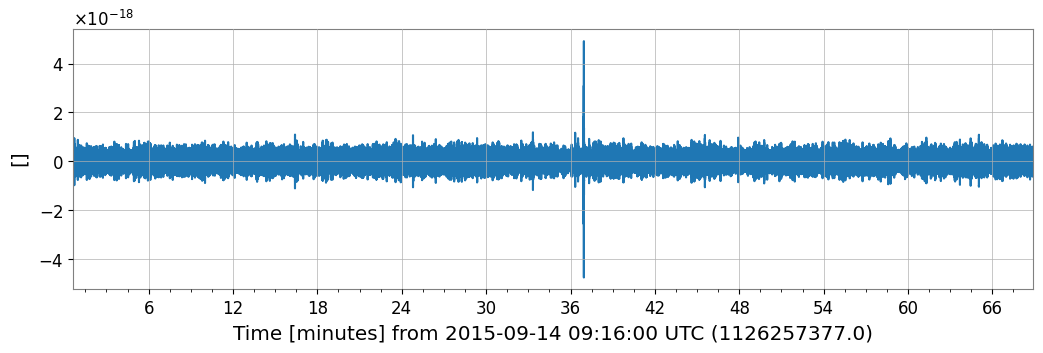

In [19]:
# Raw time-series data from GW150914

from gwpy.timeseries import TimeSeries

downsample_ratio = 100

fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
ts = TimeSeries.read(fn,format='hdf5.losc')
ts = ts[int(11*ts.size/22):int(13*ts.size/22)]
ts = ts[int(ts.size/4):int(ts.size/2)]
times = ts.times.value[::downsample_ratio]
data = ts.value[::downsample_ratio]

n_neighbors = 20
window = 20
outliers, lofs = window_lof_outliers(
    data, n_neighbors=n_neighbors, window=window, visualize=True)

Text(0.5, 0, 'Time')

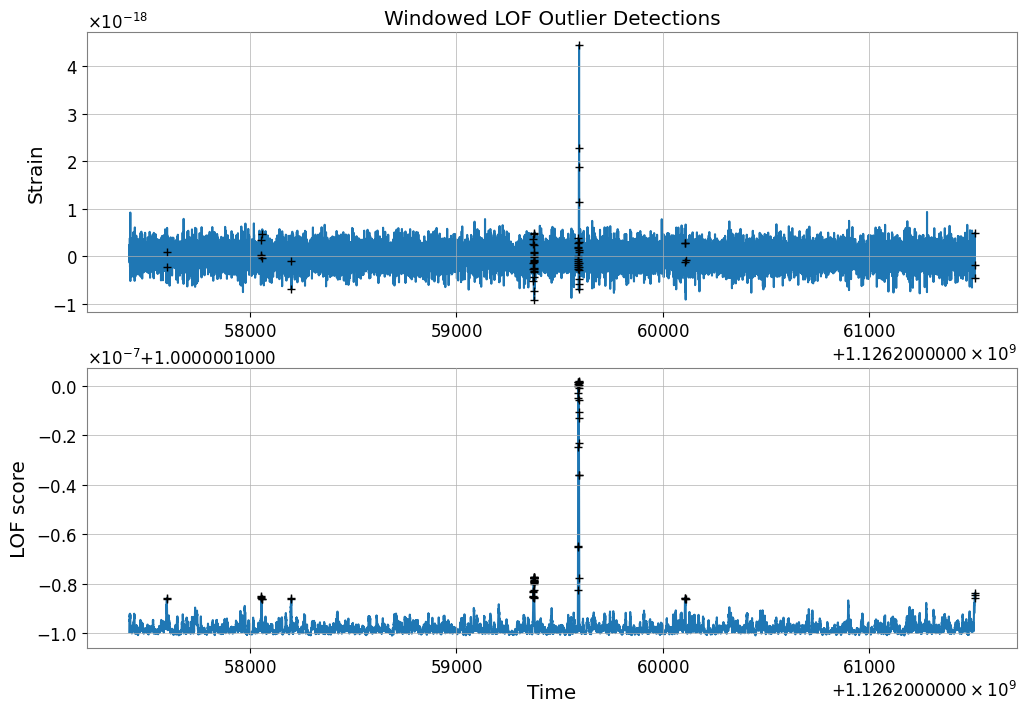

In [18]:
fig, axs = plt.subplots(2, 1, figsize=[12,8])
axs[0].plot(times, data)
axs[0].plot(times[outliers], data[outliers], 'k+')
axs[0].set_title("Windowed LOF Outlier Detections")
axs[0].set_ylabel("Strain")
axs[0].set_xlim(590+1.126259e9, 600+1.126259e9)

axs[1].plot(times, lofs)
axs[1].plot(times[outliers], lofs[outliers], 'k+')
# axs[1].plot([times[0], times[-1]], [crit_lof, crit_lof], 'r--')
axs[1].set_ylabel("LOF score")
axs[1].set_xlabel("Time")
axs[1].set_xlim(590+1.126259e9, 600+1.126259e9)

In [27]:
# Animated plots for above data
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor

class LOFWindowAnimation:
    def __init__(self, data, times=None, n_range=range(4,30), n_neighbors=20, xlim=None):
        if len(data.shape) != 1:
            raise ValueError("Input must be 1D time series")
        self.data = data
        if times is None:
            times = np.arange(0,data.size)
        self.times = times
        self.n_range = n_range
        self.n_neighbors = n_neighbors
        self.fig, self.axs = plt.subplots(
            3, 1, figsize=(8,16), gridspec_kw={'height_ratios': [2, 1, 1]})
        self.xlim = xlim
        self.anim = animation.FuncAnimation(
            self.fig, self.animate,
            init_func=self.setup_plot,
            frames=self.n_range,
            interval=1000,
            blit=True
        )

    def setup_plot(self):
        self.plots = [
            self.axs[0].scatter([], []), # tsne
            self.axs[0].scatter([], []), # tsne_outliers
            self.axs[1].plot([], [])[0], # time_series
            self.axs[1].scatter([], []), # time_series_outliers
            self.axs[2].plot([], [])[0], # lofs
            self.axs[2].scatter([], [])  # lofs_outliers
        ]
            
        self.axs[0].set_title('TSNE Plot of Data Windows')
        self.axs[1].set_title('LOF Detections in Time Series')
        self.axs[1].set_ylabel('time series')
        self.axs[2].set_xlabel('times')
        self.axs[2].set_ylabel('LOF')
        
        self.annotations = []
        
        return self.plots

    def animate(self, n):
        # Clear previous frame
        for plot in self.plots:
            plot.remove()
        
        print("Generating frame with n =", n)
        windows = self._get_rolling_windows(n)
        
        clf = LocalOutlierFactor(p=1, n_neighbors=self.n_neighbors)
        clf.fit_predict(windows)
        lofs = -clf.negative_outlier_factor_
        crit_lof = 3*np.std(lofs) + np.mean(lofs)
        is_outlier = lofs > crit_lof
        
        tsne_data = TSNE(n_components=2, perplexity=self.n_neighbors).fit_transform(windows)
        tsne_outliers = tsne_data[is_outlier]
        new_outliers = np.stack((self.times[is_outlier], self.data[is_outlier]), axis=-1)
        new_lof_detections = np.stack((self.times[is_outlier], lofs[is_outlier]), axis=-1)
        
        self.plots = [
            # tsne
            self.axs[0].scatter(
                tsne_data[:,0], tsne_data[:,1], s=10, facecolors='c', zorder=1),
            # tsne_outliers
            self.axs[0].scatter(
                tsne_outliers[:,0], tsne_outliers[:,1],
                s=150*lofs[is_outlier], facecolors='none', edgecolors='r', zorder=2),
            # time_series
            self.axs[1].plot(self.times, self.data, 'c-', zorder=1)[0],
            # time_series_outliers
            self.axs[1].scatter(
                new_outliers[:,0], new_outliers[:,1], marker='+', facecolors='k', zorder=2),
            # lofs
            self.axs[2].plot(self.times, lofs, 'c-', zorder=1)[0],
            # lofs_outliers
            self.axs[2].scatter(
                new_lof_detections[:,0], new_lof_detections[:,1],
                marker='+', facecolors='k', zorder=2)
        ]
        
        if self.xlim is not None:
            self.axs[1].set_xlim(*self.xlim)
            self.axs[2].set_xlim(*self.xlim)
        
        # Clear old annotations
        for ann in self.annotations:
            ann.remove()
        self.annotations = []
        # Generate new annotations
        self.annotations.extend([
            self.axs[i].text(
                0.01,0.02,
                f'window size = {n}',
                transform=self.axs[i].transAxes
            ) for i in range(len(self.axs))
        ])
        
        return self.plots
    
    def save(self, *args, **kwargs):
        return self.anim.save(*args, **kwargs)
    
    def show(self, *args, **kwargs):
        return HTML(self.anim.to_html5_video(*args, **kwargs))
    
    def _get_rolling_windows(self, window):
        data = self.data
        data_length = data.size
        data = np.append(data, np.full(window-1, data[-1]))
        frames = [data[i:data_length+i] for i in range(window)]
        windows = np.stack(frames, axis=-1)
        return windows

In [28]:
from gwpy.timeseries import TimeSeries

downsample_ratio = 100

fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
ts = TimeSeries.read(fn,format='hdf5.losc')
ts = ts[int(11*ts.size/22):int(13*ts.size/22)]
ts = ts[int(ts.size/4):int(ts.size/2)]
times = ts.times.value[::downsample_ratio]
data = ts.value[::downsample_ratio]

anim = LOFWindowAnimation(data, n_range=range(5,21), n_neighbors=20, xlim=(1300,1700))
plt.close()
anim.show()

Generating frame with n = 5
Generating windowed data with window size 5
Generating frame with n = 6
Generating windowed data with window size 6
Generating frame with n = 7
Generating windowed data with window size 7
Generating frame with n = 8
Generating windowed data with window size 8
Generating frame with n = 9
Generating windowed data with window size 9
Generating frame with n = 10
Generating windowed data with window size 10
Generating frame with n = 11
Generating windowed data with window size 11
Generating frame with n = 12
Generating windowed data with window size 12
Generating frame with n = 13
Generating windowed data with window size 13
Generating frame with n = 14
Generating windowed data with window size 14
Generating frame with n = 15
Generating windowed data with window size 15
Generating frame with n = 16
Generating windowed data with window size 16
Generating frame with n = 17
Generating windowed data with window size 17
Generating frame with n = 18
Generating windowed